# Introduction to Option Greeks

Option Greeks are a set of measures used to assess the risk and reward of options trading. These measures provide traders with insight into how an option's price may change based on changes in various underlying parameters, such as the underlying asset price, volatility, time to expiration, and interest rates. By understanding the behavior of option greeks, traders can make more informed trading decisions and better manage their portfolio risk.


In this notebook, we will explore the most important option greeks, including Delta, Gamma, Theta, Vega, Rho, Speed, Vega, Vomma, Charm, and Vanna, and learn how to calculate and interpret them. We will dive into each of the greeks, providing an intuitive explanation of how they work and their practical applications in trading.


We will also provide code examples using Python to calculate and visualize option greeks, including 2D and 3D plots. By the end of this notebook, you will have a solid understanding of option greeks and how to use them in your options trading strategy.

Amir Dehkordi

Email: amir.dehkordi98@gmail.com

# Table of Content

### 1. Importing the Libraries

### 2. Functions
   - 2.1. Greeks Data
   - 2.2. Normal CDF
   - 2.3. BSE Delta
   
### 3. Greeks
   - 3.1. Delta
   - 3.2. Gamma
   - 3.3. Theta
   - 3.4. Rho
   - 3.5. Vega
   - 3.6. Speed
   - 3.7. Vomma
   - 3.8. Charm
   - 3.9. Vanna
   
### 4. All-in-One

# 1. Importing the Libraries

The libraries imported in this notebook provide a range of functions and tools for analyzing option greeks.

The '**math**' library provides basic mathematical functions, such as logarithms and square roots, which are used in the Black-Scholes equation.

The '**numpy**' library is used for numerical operations and allows us to perform calculations on arrays and matrices.

The '**pandas**' library is used to manipulate and analyze data in tabular format. It provides functionality for data cleaning, transformation, and analysis.

'**yfinance**' is a library that allows us to download historical stock prices and other financial data from Yahoo Finance.

'**matplotlib.pyplot**' is a plotting library used to create visualizations such as line charts, bar charts, and histograms.

'**datetime**' is a module that supplies classes for working with dates and times.

'**pandas_datareader**' is used to retrieve data from various internet sources, such as FRED and World Bank.

'**plotly.graph_objs**' is used to create interactive visualizations and charts.

In [2]:
import math as m
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import pandas_datareader as pdr
import plotly.graph_objs as go
from scipy.stats import norm

# 2. Functions

In this notebook, we have used several custom functions for calculating option greeks.

The first function calculates the volatility of a given ticker or underlying asset based on historical data obtained from Yahoo Finance. It also calculates the dividend yield and the risk-free interest rate using data from the last year of the 1-year treasury.

The second function is used to calculate the cumulative density function of a normal distribution. This is used to calculate the probability of a stock price being above or below a certain strike price.

The third function calculates the value of N(d1), d1, N(d2), and d2. These are important variables used in the Black-Scholes equation for pricing options. N(d1) and N(d2) represent the probability that the option will be exercised, while d1 and d2 represent the sensitivity of the option price to changes in the underlying stock price and time to expiration.

## 2.1. Greeks Data
This function is used to calculate the volatility of a given underlying asset based on the historical stock prices obtained from Yahoo Finance. It calculates the daily returns of the stock, and then calculates the standard deviation of the returns, which is used as an estimate of volatility. Additionally, the function also calculates the dividend yield and the risk-free interest rate of a 1-year treasury, which are also required for Greeks.

In [3]:
def greeks_data(ticker, period='1y'):
    """Inputs:
    ticker: Ticker of the underlying asset that we try to calculate volatility.
    period: The date range where we want to download the data.
    Output: The volatility/standard deviation of the returns, the dividend yield of 
    the stock, and the risk free interest rate."""
    # Download the data from yahoo finance
    stock = yf.Ticker(ticker)
    df = stock.history(period='1y')
    
    # Calculate the Volatility
    # Calculate the daily returns
    df_rets = df['Close'].apply(lambda x: m.log(x)) - df['Close'].shift(1).apply(lambda x: m.log(x))
    volatility = df_rets[1:].std() # Remove the first NaN value and calculate the volatility
    
    # Calculate the Dividend Yield
    div_yield = df['Dividends'].sum()/df['Close'].mean()
    
    #Calculate the Risk-free Interest rate
    # Define the data source (FRED) and the risk-free interest rate ticker symbol
    data_source = 'fred'
    rf_rate_ticker = 'DGS1'

    # Get the risk-free interest rate data
    rf_rate = pdr.DataReader(rf_rate_ticker, data_source)
    rf_rate = rf_rate['DGS1'].iloc[-1]/100
    
    return volatility, div_yield, rf_rate


In [4]:
# Define the stock ticker symbol 
tick = "AAPL"
# Example
list(greeks_data(ticker=tick, period='2y'))

[0.021804772175553003, 0.006166791874634106, 0.045]

## 2.2. Normal CDF
This function is used to calculate the cumulative distribution function of a normal distribution. It takes a value 'x' and mean and standard deviation of a normal distribution, and returns the probability of observing a value less than or equal to 'x' from that distribution.

In [5]:
# Defining the cummulative density function of a normal distribution
def normal_cdf(mu, sigma, x):
    """Inputs:
    mu: The expected value/mean of the function.
    sigma: Standard deviation of the function.
    x: Value of the X in the C.D.F.
    Output: Cummulative density function of a normal distribution."""
    # Calculating the cummulative density function
    cdf = 1/2*(1+m.erf((x-mu) / (sigma*m.sqrt(2))))
    return cdf


## 2.3. BSE Data
This function is used to calculate the option greeks - N(d1), d1, N(d2) and d2. These are required for pricing options using the Black-Scholes formula. N(d1) and N(d2) represent the cumulative probability of observing a random variable from a standard normal distribution less than or equal to d1 and d2, respectively. d1 and d2 are terms used in the Black-Scholes formula and are calculated based on the stock price, strike price, time to maturity, volatility, and risk-free interest rate.

In [6]:
def bse_delta(ex_price, int_rate, div_yield, cur_price, time, option_type, vol):
    """Inputs:
    ex_price: Exercise price of the option.
    int_rate: Risk-free interest rate.
    cur_price: Current underlying price of the asset.
    time: Time to expiry of the option.
    vol: Volatility of the option.
    option_type: Type of the option whether Call or Put.
    Output: N(d1) and N(d2) for calculating the Call Option
    """
    # calculating d1 and d2
    d1 = (m.log(cur_price/ex_price)+(int_rate - div_yield + (vol**2)/2)*time )/(vol * m.sqrt(time))
    d2 = (m.log(cur_price/ex_price)+(int_rate - div_yield - (vol**2)/2)*time )/(vol * m.sqrt(time))
    
    # use 'normal_cdf' to calculate N(d1) and N(d2)
    N_d1 = normal_cdf(0, 1, d1)
    N_d2 = normal_cdf(0, 1, d2)
    
    # Return the values of N based on the type of the option.
    if option_type == 'call':
        return N_d1, N_d2, d1, d2
    
    elif option_type == 'put':
        return (1-N_d1), (1-N_d2), d1, d2


In [7]:
tick = 'AAPL' # Ticker of the Underlying
S = 160 # Underlying price
K = 165 # Exercise price
T = 1 # Time to maturity
# Using the function to calculate Greeks data (Volatility, Dividend Yield, RF Interest rate)
sigma, q, r = greeks_data(ticker=tick, period='1y')

# Using the functions to calculate the values of N_d1 and N_d2
N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=S,
                           div_yield=q, time=T, option_type='call', vol=sigma)

# 3. Greeks
Option Greeks are financial metrics used to measure the sensitivity of option prices to changes in different variables such as the underlying asset price, time to expiration, implied volatility, and interest rates. These metrics are essential for options traders and investors to assess and manage risk and make informed trading decisions. The five main Greeks are Delta, Gamma, Theta, Vega, and Rho. 

## 3.1. Delta
Delta is a measure of the rate of change of an option's price in relation to the price of the underlying asset. It measures the sensitivity of an option's price to changes in the price of the underlying asset, and is represented by a value between 0 and 1 for call options and between 0 and -1 for put options.

A delta of 0.5, for example, indicates that the option's price will increase by £0.50 for every £1.00 increase in the underlying asset's price, while a delta of -0.5 indicates that the option's price will decrease by £0.50 for every £1.00 increase in the underlying asset's price.

Delta is an important parameter in option pricing and risk management, as it can be used to hedge against changes in the price of the underlying asset.

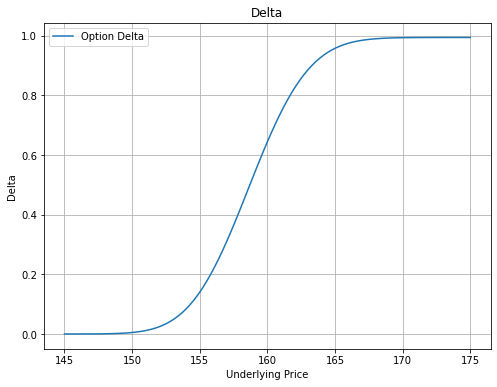

In [8]:
# Get the values of Delta w.r.t. changes in Underlying price
delta = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Delta for each underlying price
    d = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[0]
    d = m.exp(-q*T) * d # Calculate value of Delta
    delta.append(d)
    
# Plot the Delta values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), delta, label='Option Delta')
plt.title('Delta')
plt.xlabel('Underlying Price')
plt.ylabel('Delta')
plt.legend()
plt.grid();

In [9]:
# Get the values of Delta w.r.t. changes in the Underlying price and Time to expiry
deltaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Delta w.r.t. the Underlying price
    deltaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Delta w.r.t. the Time to expiry
            d = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=j, option_type='call', vol=sigma)[0]
            d = m.exp(-q*T) * d # Calculate value of Delta
            deltaT.append(d)
    deltaUT.append(deltaT) # Append the list to the deltaT to create a DataFrame

In [10]:
# Convert the list of Deltas to a Dataframe
df_delta = pd.DataFrame(deltaUT)
df_delta.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_delta.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_delta.head()

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.103398e-16,1.153050e-14,...,0.846537,0.854676,0.862428,0.869806,0.876822,0.883489,0.889821,0.895831,0.901530,0.906933
145.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.310193e-16,3.409499e-14,...,0.856517,0.864222,0.871551,0.878518,0.885135,0.891416,0.897374,0.903022,0.908373,0.913439
145.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.048228e-15,9.891959e-14,...,0.866005,0.873286,0.880203,0.886769,0.892999,0.898905,0.904501,0.909801,0.914815,0.919559
145.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.420532e-15,2.807595e-13,...,0.875011,0.881878,0.888393,0.894571,0.900426,0.905970,0.911217,0.916180,0.920872,0.925305
146.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.092364e-14,7.797159e-13,...,0.883543,0.890007,0.896133,0.901935,0.907427,0.912622,0.917533,0.922173,0.926555,0.930691


In [11]:
"""This is a dynamic 3D plot for the Option's Delta surface"""
# # Creating the Option Delta surface
# fig = go.Figure(data=[go.Surface(z=df_delta.values)])
# fig.update_layout(title='3D plot of an Option Delta', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Delta'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Delta surface"

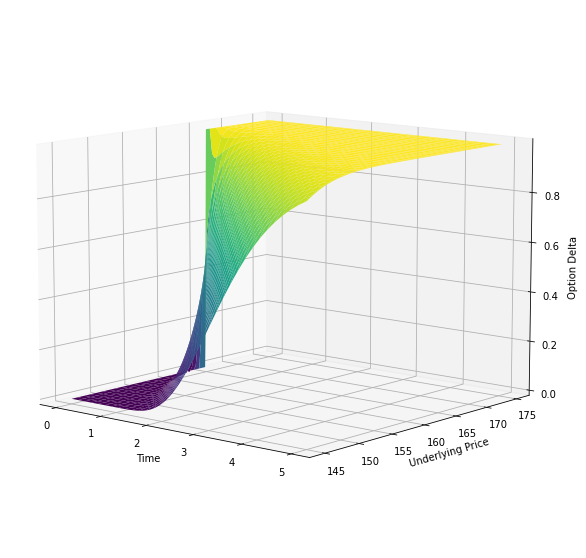

In [12]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_delta.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Delta')
ax.view_init(elev=10, azim=310);

## 3.2. Gamma
Gamma is a measure of the rate of change in an option's delta for a given change in the price of the underlying asset. It is the second partial derivative of the option price with respect to the price of the underlying asset.

A high gamma value indicates that the delta of the option will change quickly in response to changes in the price of the underlying asset, while a low gamma value indicates that the delta of the option will change more slowly.

Gamma is highest for at-the-money options and decreases as the option moves further in or out of the money. When an option is deep in or out of the money, the gamma value will be close to zero.

Gamma is an important greek to consider when trading options as it can help determine the optimal strike price to trade and how to hedge the position against price movements in the underlying asset.

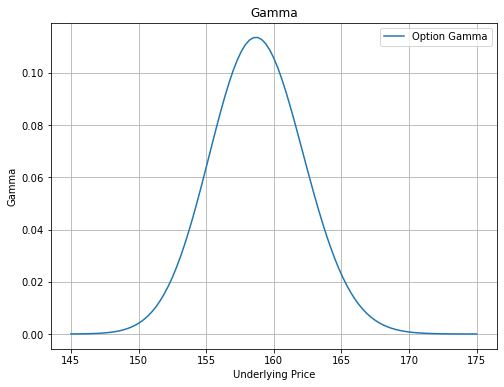

In [13]:
# Get the values of Gamma w.r.t. changes in Underlying price
gamma = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Gamma for each underlying price
    g = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[2]
    g = m.exp(-q*T) * m.exp(-g**2/2) / (S*sigma*m.sqrt(2*m.pi*T)) # Calculate value of Gamma
    gamma.append(g)
    
# Plot the Gamma values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), gamma, label='Option Gamma')
plt.title('Gamma')
plt.xlabel('Underlying Price')
plt.ylabel('Gamma')
plt.legend()
plt.grid();

In [14]:
# Get the values of Gamma w.r.t. changes in the Underlying price and Time to expiry
gammaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Gamma w.r.t. the Underlying price
    gammaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Gamma w.r.t. the Time to expiry
        g = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)[2]
        g = m.exp(-q*T) * m.exp(-g**2/2) / (S*sigma*m.sqrt(2*m.pi*T)) # Calculate value of Delta
        gammaT.append(g)
    gammaUT.append(gammaT) # Append the list to the gammaT to create a DataFrame

In [15]:
# Convert the list of Gammas to a Dataframe
df_gamma = pd.DataFrame(gammaUT)
df_gamma.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_gamma.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_gamma.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,1.348533e-149,2.215027e-73,5.341340e-48,2.520109e-35,9.811992e-28,1.097415e-22,4.330794e-19,2.113500e-16,2.560129e-14,...,0.065895,0.063417,0.060978,0.058581,0.056231,0.053931,0.051684,0.049492,0.047358,0.045283
145.3,0.0,7.867397e-145,4.914806e-71,1.849920e-46,3.448321e-34,7.690527e-27,5.932576e-22,1.795588e-18,7.181521e-16,7.451717e-14,...,0.062845,0.060402,0.058003,0.055652,0.053353,0.051108,0.048920,0.046791,0.044722,0.042714


In [16]:
"This is a dynamic 3D plot for the Option's Gamma surface"""
# # Creating the Option Gamma surface
# fig = go.Figure(data=[go.Surface(z=df_gamma.values)])
# fig.update_layout(title='3D plot of an Option Gamma', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Gamma'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))  
# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Gamma surface"

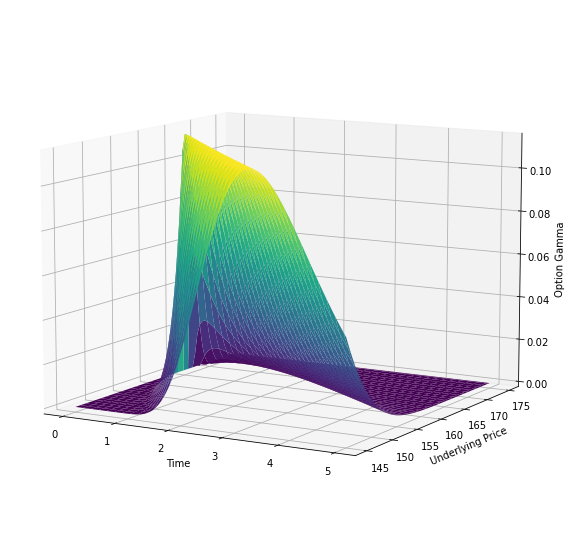

In [17]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_gamma.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Gamma')
ax.view_init(elev=10, azim=300);

## 3.3. Theta
Theta is an option Greek that measures the rate of decline of an option's time value due to the passage of time, also known as time decay. It measures the sensitivity of an option's price to a change in time, assuming all other variables remain constant. Theta is negative for all options and the rate of time decay accelerates as the option approaches expiration.

The formula for calculating theta involves the partial derivative of the option price with respect to time. A higher theta means that the option's time decay is happening more quickly, which can be beneficial for short-term option traders who are looking to capitalize on quick moves in the market. However, long-term option traders may want to be cautious of high theta values, as the rapid time decay can erode the option's value over time.

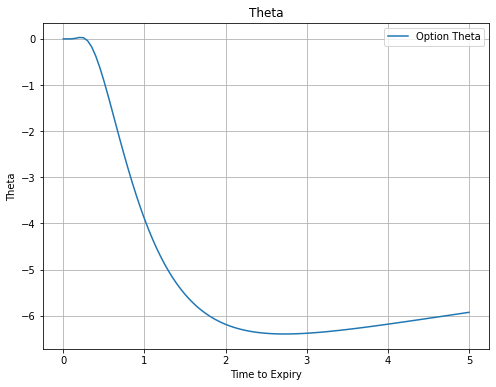

In [18]:
# Get the values of Theta w.r.t. changes in Time to Expiry
theta = []
for i in np.linspace(0.000001, 5, 101):
    # Using the functions to iterate and get the value of Theta for time step
    N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=S,
                div_yield=q, time=i, option_type='call', vol=sigma)
    n_d1 = norm.pdf(d1) # Calculate the standard normal probability density function for d1
    # Calculate value of Theta
    t =  ((S*sigma*n_d1)/(2*m.sqrt(i))) - (r*K*m.exp(-r*i)*N_d2)
    theta.append(t)
    
# Plot the Theta values w.r.t. Time to Expiry
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0.000001, 5, 101), theta, label='Option Theta')
plt.title('Theta')
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.legend()
plt.grid();

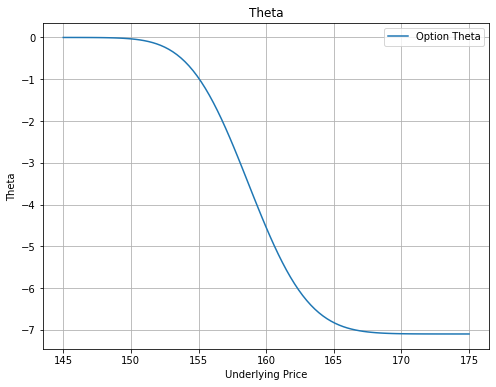

In [19]:
# Get the values of Theta w.r.t. changes in Underlying price
theta = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Theta for each underlying price
    N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)
    n_d1 = norm.pdf(d1) # Calculate normal probability density function for d1
    # Calculate value of Theta
    t = -(1/365) * ((i*sigma*n_d1)/(2*m.sqrt(T))) - (r*K*m.exp(-r*T)*N_d2)
    theta.append(t)
    
# Plot the Theta values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), theta, label='Option Theta')
plt.title('Theta')
plt.xlabel('Underlying Price')
plt.ylabel('Theta')
plt.legend()
plt.grid();

In [20]:
# Get the values of Theta w.r.t. changes in the Underlying price and Time to expiry
thetaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Theta w.r.t. the Underlying price
    thetaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Theta w.r.t. the Time to expiry
        N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=T, option_type='call', vol=sigma)
        n_d1 = norm.pdf(d1) # Calculate normal probability density function for d1
        # Calculate value of Theta
        t = -(1/365) * ((i*sigma*n_d1)/(2*m.sqrt(j))) - (r*K*m.exp(-r*j)*N_d2)
        thetaT.append(t)
    thetaUT.append(thetaT) # Append the list to the thetaT to create a DataFrame

In [21]:
# Convert the list of Thetas to a Dataframe
df_theta = pd.DataFrame(thetaUT)
df_theta.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_theta.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_theta.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,-0.000456,-0.000122,-0.000121,-0.000120,-0.000120,-0.00012,-0.000119,-0.000119,-0.000119,-0.000118,...,-0.000098,-0.000098,-0.000098,-0.000098,-0.000097,-0.000097,-0.000097,-0.000097,-0.000096,-0.000096
145.3,-0.000678,-0.000183,-0.000182,-0.000181,-0.000181,-0.00018,-0.000180,-0.000179,-0.000179,-0.000178,...,-0.000148,-0.000148,-0.000147,-0.000147,-0.000147,-0.000146,-0.000146,-0.000146,-0.000145,-0.000145


In [22]:
"This is a dynamic 3D plot for the Option's Theta surface"""
# # Creating the Option theta surface
# fig = go.Figure(data=[go.Surface(z=df_theta.values)])
# fig.update_layout(title='3D plot of an Option Theta', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Theta'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))  
# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Theta surface"

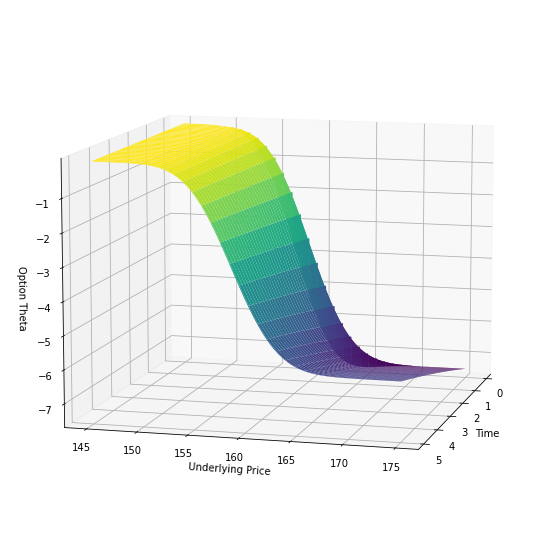

In [23]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_theta.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Theta')
ax.view_init(elev=10, azim=15);

## 3.4. Rho
Rho is one of the option Greeks that measures the sensitivity of an option's value to a change in the risk-free interest rate. It represents the expected change in an option's price for a 1% change in the risk-free interest rate.

For call options, rho is positive, which means that an increase in the risk-free interest rate will increase the value of the call option. For put options, rho is negative, which means that an increase in the risk-free interest rate will decrease the value of the put option.

Rho is an important factor to consider when interest rates are expected to change, especially in long-term options. In general, options with longer expiration dates have higher rho values than those with shorter expiration dates.

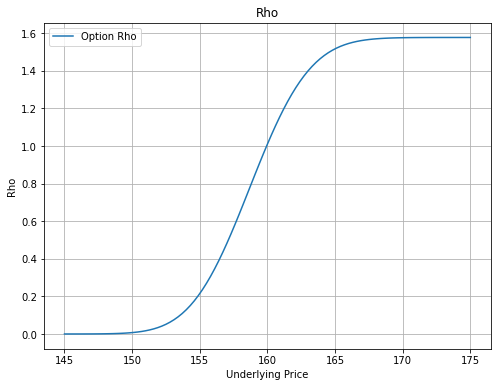

In [24]:
# Get the values of Rho w.r.t. changes in Underlying price
rho = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Rho for each underlying price
    N_d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[1]
    # Calculate value of rho
    rh = K*T*np.exp(-r*T)*N_d2 / 100
    rho.append(rh)
    
# Plot the rho values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), rho, label='Option Rho')
plt.title('Rho')
plt.xlabel('Underlying Price')
plt.ylabel('Rho')
plt.legend()
plt.grid();

In [25]:
# Get the values of Rho w.r.t. changes in the Underlying price and Time to expiry
rhoUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Rho w.r.t. the Underlying price
    rhoT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Rho w.r.t. the Time to expiry
        N_d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)[1]
        # Calculate value of rho
        rh = K*T*np.exp(-r*T)*N_d2 / 100
        rhoT.append(rh)
    rhoUT.append(rhoT) # Append the list to the rhoT to create a DataFrame

In [26]:
# Convert the list of Rhos to a Dataframe
df_rho = pd.DataFrame(rhoUT)
df_rho.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_rho.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_rho.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.756306e-17,1.628673e-14,...,1.326202,1.339665,1.352512,1.364762,1.376434,1.387548,1.398123,1.408178,1.417734,1.426808
145.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.378153e-16,4.842237e-14,...,1.342827,1.355599,1.367770,1.379361,1.390392,1.400883,1.410853,1.420323,1.429312,1.437839


In [27]:
"This is a dynamic 3D plot for the Option's Rho surface"""
# # Creating the Option rho surface
# fig = go.Figure(data=[go.Surface(z=df_rho.values)])
# fig.update_layout(title='3D plot of an Option Rho', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Rho'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))  
# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Rho surface"

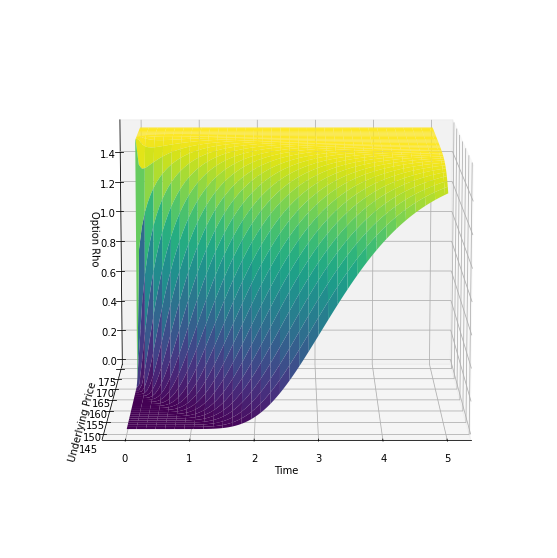

In [28]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_rho.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Rho')
ax.view_init(elev=10, azim=270);

## 3.5. Vega
Vega is a measure of an option's sensitivity to changes in implied volatility, which is a market's estimate of how much an asset's price will fluctuate over time. Specifically, it measures the change in the price of an option per unit change in implied volatility. Vega is typically expressed as a positive number, and the higher the vega, the more sensitive the option's price is to changes in implied volatility.

Vega is an important factor in option pricing, as implied volatility is one of the key components in the Black-Scholes model. Options with higher implied volatility have higher premiums, all else being equal, because they are more likely to experience larger price movements. Vega helps traders to manage their exposure to volatility risk, as well as to identify potentially undervalued or overvalued options.

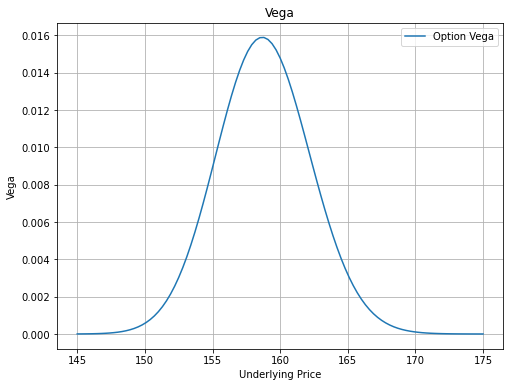

In [29]:
# Get the values of Vega w.r.t. changes in Underlying price
vega = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Vega for each underlying price
    d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[2]
    v = S*m.exp(-q*T)*m.exp(-d1**2/2)*m.sqrt(T)/(100*100) # Calculate value of Vega
    vega.append(v)
    
# Plot the vega values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), vega, label='Option Vega')
plt.title('Vega')
plt.xlabel('Underlying Price')
plt.ylabel('Vega')
plt.legend()
plt.grid();

In [30]:
# Get the values of Vega w.r.t. changes in the Underlying price and Time to expiry
vegaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Vega w.r.t. the Underlying price
    vegaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Vega w.r.t. the Time to expiry
        d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)[2]
        v = S*m.exp(-q*T)*m.exp(-d1**2/2)*m.sqrt(T)/(100*100) # Calculate value of Vega
        vegaT.append(v)
    vegaUT.append(vegaT) # Append the list to the vegaT to create a DataFrame

In [31]:
# Convert the list of Vegas to a Dataframe
df_vega = pd.DataFrame(vegaUT)
df_vega.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_vega.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_vega.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,1.886874e-150,3.099278e-74,7.473633e-49,3.526151e-36,1.372899e-28,1.535509e-23,6.059672e-20,2.957222e-17,3.582147e-15,...,0.009220,0.008873,0.008532,0.008197,0.007868,0.007546,0.007232,0.006925,0.006626,0.006336
145.3,0.0,1.100811e-145,6.876824e-72,2.588418e-47,4.824909e-35,1.076063e-27,8.300893e-23,2.512397e-19,1.004842e-16,1.042648e-14,...,0.008793,0.008451,0.008116,0.007787,0.007465,0.007151,0.006845,0.006547,0.006257,0.005977


In [32]:
"""This is a dynamic 3D plot for the Option's Vega surface"""
# # Creating the Option Vega surface
# fig = go.Figure(data=[go.Surface(z=df_vega.values)])
# fig.update_layout(title='3D plot of an Option Vega', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Vega'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Vega surface"

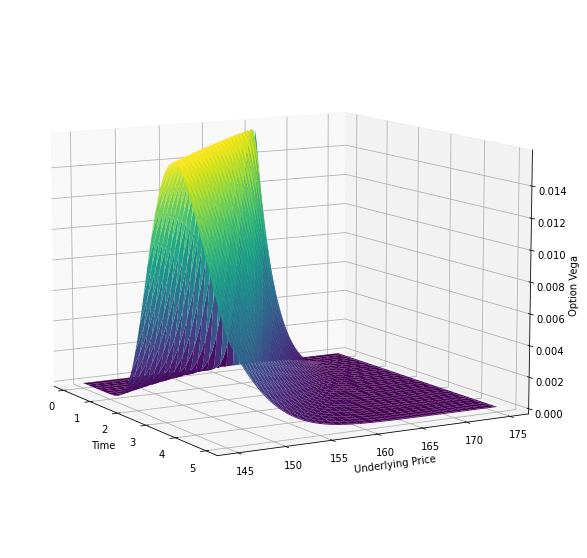

In [33]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_vega.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Vega')
ax.view_init(elev=10, azim=330);

## 3.6. Speed
The "speed" is a second-order derivative of the option price with respect to the price of the underlying asset, and is used to measure the rate of change of the option's delta. It represents the acceleration or deceleration of the delta as the underlying asset price changes. A positive speed indicates that the option's delta is increasing at an increasing rate, while a negative speed indicates that the option's delta is decreasing at an increasing rate. The speed is less commonly used than the other Greeks, as it is less sensitive to changes in the underlying asset price and more difficult to calculate accurately.

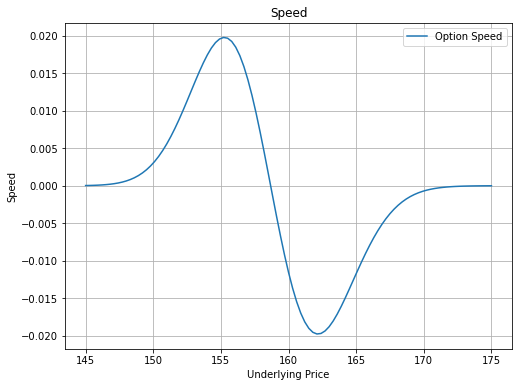

In [34]:
# Get the values of Speed w.r.t. changes in Underlying price
speed = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Speed for each underlying price
    d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[2]
    g = m.exp(-q*T) * m.exp(-d1**2/2) / (S*sigma*m.sqrt(2*m.pi*T)) # Calculate value of Gamma
    s = -g*d1/(S*sigma*m.sqrt(T)) # Calculate value of Speed
    speed.append(s)
    
# Plot the Speed values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), speed, label='Option Speed')
plt.title('Speed')
plt.xlabel('Underlying Price')
plt.ylabel('Speed')
plt.legend()
plt.grid();

In [35]:
# Get the values of Speed w.r.t. changes in the Underlying price and Time to expiry
speedUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Speed w.r.t. the Underlying price
    speedT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Speed w.r.t. the Time to expiry
        d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)[2]
        g = m.exp(-q*T) * m.exp(-d1**2/2) / (S*sigma*m.sqrt(2*m.pi*T)) # Calculate value of Gamma
        s = -g*d1/(S*sigma*m.sqrt(T)) # Calculate value of Speed
        speedT.append(s)
    speedUT.append(speedT) # Append the list to the speedT to create a DataFrame

In [36]:
# Convert the list of Speeds to a Dataframe
df_speed = pd.DataFrame(speedUT)
df_speed.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_speed.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_speed.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,1.008868e-148,1.153774e-72,2.236263e-47,8.992695e-35,3.081253e-27,3.094487e-22,1.111809e-18,4.989571e-16,5.600308e-14,...,-0.019720,-0.019635,-0.019504,-0.019331,-0.019120,-0.018874,-0.018597,-0.018292,-0.017961,-0.017608
145.3,0.0,5.790189e-144,2.517821e-70,7.615298e-46,1.209541e-33,2.373261e-26,1.643438e-21,4.527204e-18,1.664569e-15,1.599890e-13,...,-0.019608,-0.019466,-0.019283,-0.019062,-0.018807,-0.018520,-0.018206,-0.017868,-0.017507,-0.017128


In [37]:
"""This is a dynamic 3D plot for the Option's Speed surface"""
# # Creating the Option Speed surface
# fig = go.Figure(data=[go.Surface(z=df_speed.values)])
# fig.update_layout(title='3D plot of an Option Speed', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Speed'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Speed surface"

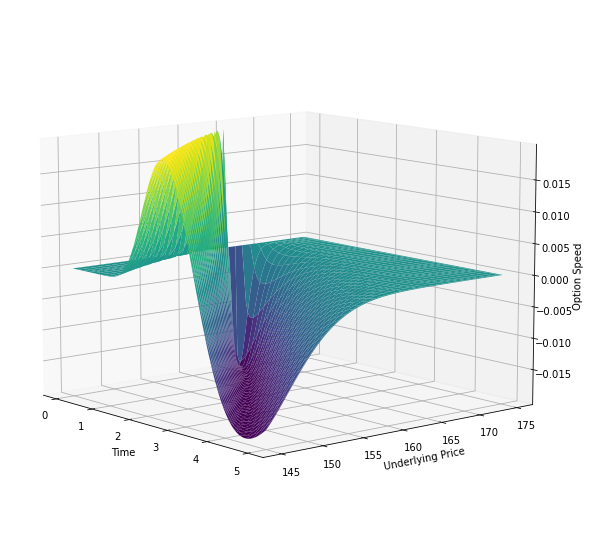

In [38]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_speed.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Speed')
ax.view_init(elev=10, azim=320);

## 3.7. Vomma
Vomma, also known as Volga, is the second-order derivative of an option's value with respect to changes in implied volatility. It measures the sensitivity of the option's vega to changes in implied volatility. When implied volatility changes, it affects the option's value, and vomma helps measure how much the vega changes in response.

Vomma is an important Greek because it can help traders manage their vega risk. If a trader has a long vega position, then a positive vomma means that the vega will increase if the implied volatility increases. Conversely, if a trader has a short vega position, then a negative vomma means that the vega will decrease if the implied volatility increases. Therefore, traders can use vomma to determine how much they need to hedge their vega risk in response to changes in implied volatility.

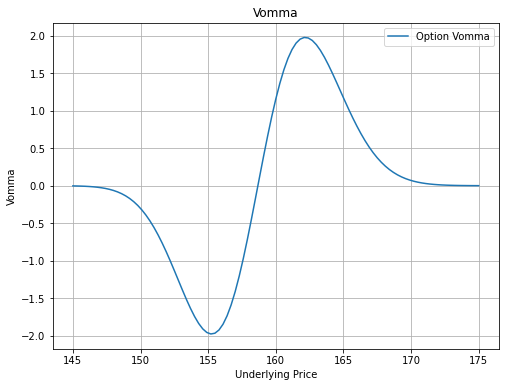

In [39]:
# Get the values of Vomma w.r.t. changes in Underlying price
vomma = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Vomma for each underlying price
    d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)[2]
    veg = S*m.exp(-q*T)*m.exp(-d1**2/2)*m.sqrt(T)/(100*100) # Calculate value of Vega
    v = veg*d1*d2/sigma
    vomma.append(v)
    
# Plot the vomma values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), vomma, label='Option Vomma')
plt.title('Vomma')
plt.xlabel('Underlying Price')
plt.ylabel('Vomma')
plt.legend()
plt.grid();

In [40]:
# Get the values of Vomma w.r.t. changes in the Underlying price and Time to expiry
vommaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Vomma w.r.t. the Underlying price
    vommaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Vomma w.r.t. the Time to expiry
        d1 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)[2]
        veg = S*m.exp(-q*T)*m.exp(-d1**2/2)*m.sqrt(T)/(100*100) # Calculate value of Vega
        v = veg*d1*d2/sigma
        vommaT.append(v)
    vommaUT.append(vommaT) # Append the list to the vommaT to create a DataFrame

In [41]:
# Convert the list of Vommas to a Dataframe
df_vomma = pd.DataFrame(vommaUT)
df_vomma.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_vomma.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_vomma.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,-0.0,-1.009262e-146,-1.154223e-70,-2.237134e-45,-8.996201e-33,-3.082454e-25,-3.095694e-20,-1.112243e-16,-4.991516e-14,-5.602491e-12,...,1.972782,1.964223,1.951130,1.933861,1.912764,1.888183,1.860451,1.829889,1.796808,1.761506
145.3,-0.0,-5.792446e-142,-2.518802e-68,-7.618267e-44,-1.210012e-31,-2.374186e-24,-1.644079e-19,-4.528969e-16,-1.665218e-13,-1.600514e-11,...,1.961564,1.947377,1.929051,1.906943,1.881400,1.852757,1.821339,1.787459,1.751416,1.713493


In [42]:
"""This is a dynamic 3D plot for the Option's Vomma surface"""
# # Creating the Option Vomma surface
# fig = go.Figure(data=[go.Surface(z=df_vomma.values)])
# fig.update_layout(title='3D plot of an Option vomma', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Vomma'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Vomma surface"

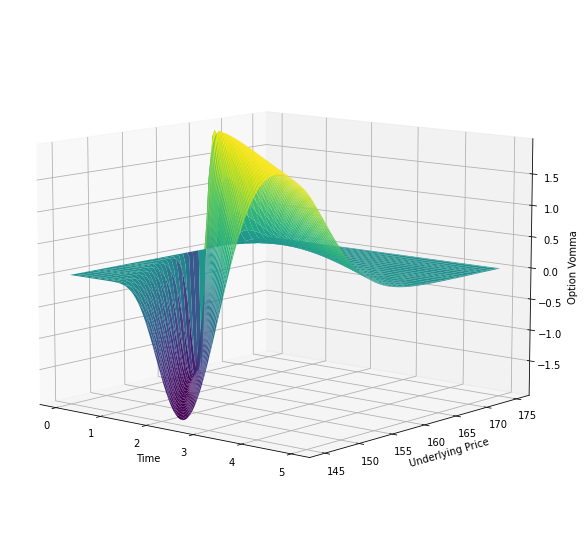

In [43]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_vomma.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Vomma')
ax.view_init(elev=10, azim=310);

## 3.8. Charm
Charm is a second-order derivative of the option price with respect to time. It is a measure of how the delta of an option changes as the time to expiration changes. More specifically, it measures the rate of change of delta with respect to time. A positive charm indicates that the delta of a call option increases as the time to expiration decreases, while the delta of a put option decreases as the time to expiration decreases. A negative charm indicates the opposite.

The charm is an important greek to consider when trading options with short expirations, as the effect of time decay on the option delta can be significant. Traders can use charm to adjust their positions as the time to expiration changes, helping them to manage risk and maximize profits.

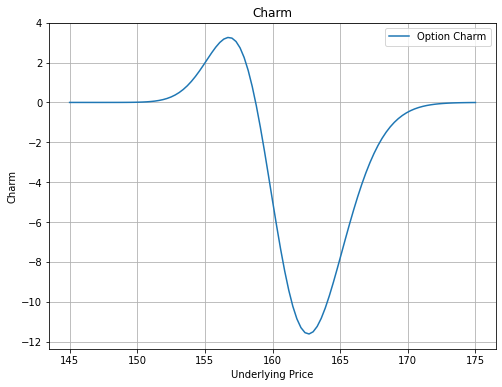

In [44]:
# Get the values of Charm w.r.t. changes in Underlying price
charm = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Charm for each underlying price
    N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)
    c = -m.exp(-q*T) * (N_d1*d2*m.exp(-d1**2/2))/(2*T*sigma*m.sqrt(T)) # Calculate the value of Charm
    charm.append(c)
    
# Plot the Charm values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), charm, label='Option Charm')
plt.title('Charm')
plt.xlabel('Underlying Price')
plt.ylabel('Charm')
plt.legend()
plt.grid();

In [45]:
# Get the values of Charm w.r.t. changes in the Underlying price and Time to expiry
charmUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Charm w.r.t. the Underlying price
    charmT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of charm w.r.t. the Time to expiry
        N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)
        # Calculate the value of Charm
        c = -m.exp(-q*T) * (N_d1*d2*m.exp(-d1**2/2))/(2*T*sigma*m.sqrt(T))
        charmT.append(c)
    charmUT.append(charmT) # Append the list to the charmT to create a DataFrame

In [46]:
# Convert the list of charms to a Dataframe
df_charm = pd.DataFrame(charmUT)
df_charm.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_charm.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_charm.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.881964e-29,4.554299e-25,...,-11.22780,-11.301360,-11.341572,-11.350078,-11.328628,-11.279046,-11.203214,-11.103042,-10.980452,-10.837359
145.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.885302e-28,3.847314e-24,...,-11.31706,-11.349721,-11.350735,-11.321906,-11.265113,-11.182282,-11.075366,-10.946320,-10.797089,-10.629588


In [47]:
"""This is a dynamic 3D plot for the Option's Charm surface"""
# # Creating the Option Charm surface
# fig = go.Figure(data=[go.Surface(z=df_charm.values)])
# fig.update_layout(title='3D plot of an Option Charm', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Charm'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # Show the plot
# fig.show()

"This is a dynamic 3D plot for the Option's Charm surface"

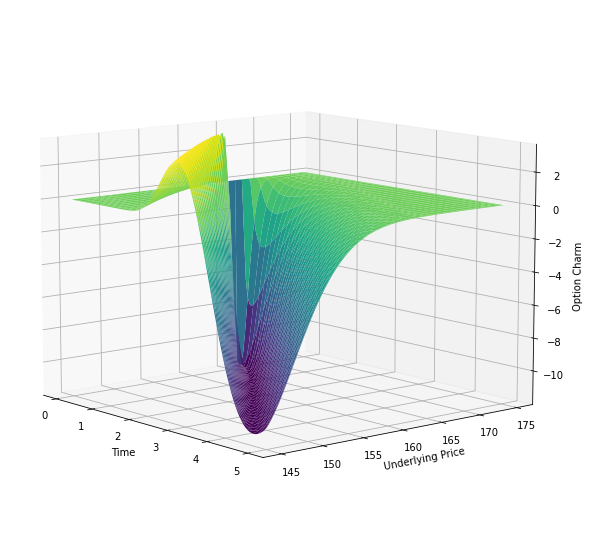

In [48]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_charm.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Charm')
ax.view_init(elev=10, azim=320);

## 3.9. Vanna
Vanna is a second-order option Greek that measures the sensitivity of the option's delta to changes in the implied volatility of the underlying asset. More specifically, it measures the rate of change in the delta of an option for a unit change in the implied volatility of the underlying asset.

In other words, Vanna is a measure of how much the delta of an option changes when the implied volatility of the underlying asset changes. A positive Vanna means that the option's delta increases as the implied volatility of the underlying asset increases, while a negative Vanna means that the option's delta decreases as the implied volatility of the underlying asset increases.

Vanna is an important risk measure for options traders because it helps them manage their exposure to changes in implied volatility. For example, if a trader is long an option and has a positive Vanna, they may want to adjust their position if they expect a decrease in implied volatility.

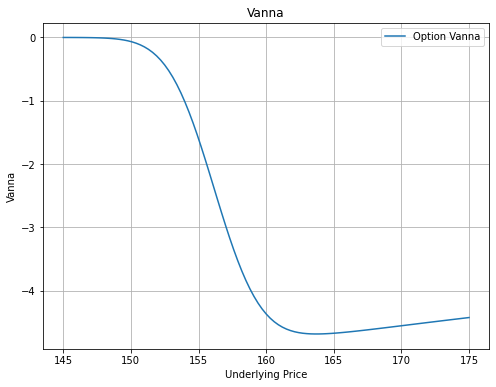

In [49]:
# Get the values of Vanna w.r.t. changes in Underlying price
vanna = []
for i in np.linspace(S-15, S+15, 101):
    # Using the functions to iterate and get the value of Vanna for each underlying price
    N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                div_yield=q, time=T, option_type='call', vol=sigma)
    v = -(m.exp(-N_d1**2/N_d2)*N_d2)/(i*(sigma**2)*T) # Calculate the value of Vanna
    vanna.append(v)
    
# Plot the Vanna values w.r.t. Underlying price
plt.figure(figsize=(8,6))
plt.plot(np.linspace(S-15, S+15, 101), vanna, label='Option Vanna')
plt.title('Vanna')
plt.xlabel('Underlying Price')
plt.ylabel('Vanna')
plt.legend()
plt.grid();

In [50]:
# Get the values of Vanna w.r.t. changes in the Underlying price and Time to expiry
vannaUT = []
for i in np.linspace(S-15, S+15, 101):
    # Iterating to get values of Vanna w.r.t. the Underlying price
    vannaT = []
    for j in np.linspace(0.000001, 5, 101):
        # Iterating to get values of Vanna w.r.t. the Time to expiry
        N_d1, N_d2, d1, d2 = bse_delta(ex_price=K, int_rate=r, cur_price=i,
                    div_yield=q, time=j, option_type='call', vol=sigma)
        if (N_d1 or N_d2) == 0:
            v = 0
        else:
            v = -(m.exp(-N_d1**2/N_d2)*N_d2)/(i*(sigma**2)*T) # Calculate the value of Vanna
        vannaT.append(v)
    vannaUT.append(vannaT) # Append the list to the vannaT to create a DataFrame

In [51]:
# Convert the list of vannas to a Dataframe
df_vanna = pd.DataFrame(vannaUT)
df_vanna.columns = list(np.linspace(0.000001, 5, 101)) # Change the columns to Time to expiry
df_vanna.index = list(np.linspace(S-15, S+15, 101)) # Change the rows to Underlying price
df_vanna.head(2)

,0.000001,0.050001,0.100001,0.150001,0.200001,0.250001,0.300001,0.350001,0.400001,0.450001,...,4.550000,4.600000,4.650000,4.700000,4.750000,4.800000,4.850000,4.900000,4.950000,5.000000
145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.052096e-16,-1.497690e-13,...,-5.145506,-5.157186,-5.168022,-5.178088,-5.187447,-5.196159,-5.204279,-5.211855,-5.218931,-5.225549
145.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.017736e-15,-4.443616e-13,...,-5.149954,-5.160606,-5.170496,-5.179689,-5.188244,-5.196215,-5.203650,-5.210593,-5.217084,-5.223160


In [52]:
"""This is a dynamic 3D plot for the Option's Vanna surface"""
# # Creating the Option Vanna surface
# fig = go.Figure(data=[go.Surface(z=df_vanna.values)])
# fig.update_layout(title='3D plot of an Option Vanna', autosize=False, width=800, height=800,
#         margin=dict(l=50, r=50, b=65, t=90),
#         scene=dict(xaxis_title='Time', yaxis_title='Underlying Price', zaxis_title='Option Vanna'))
# fig.update_traces(y=list(np.linspace(S-15, S+15, 101)), x=list(np.linspace(0.000001, 5, 101)))

# # # Show the plot
# # fig.show()

"This is a dynamic 3D plot for the Option's Vanna surface"

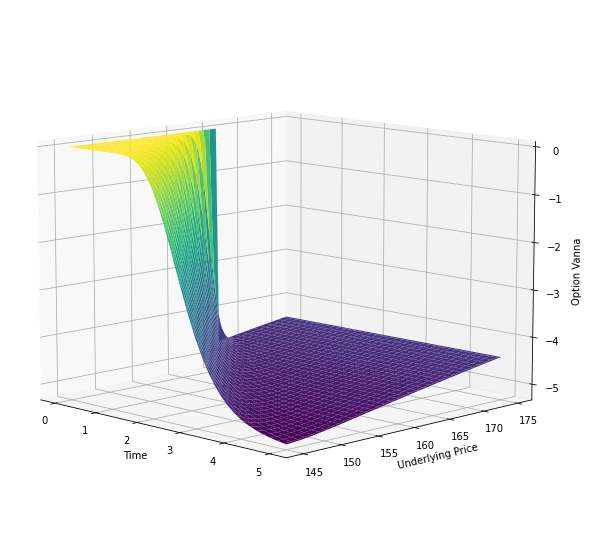

In [53]:
# Create a static 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0.000001, 5, 101)
y = np.linspace(S-15, S+15, 101)
x, y = np.meshgrid(x, y)
z = df_vanna.values
ax.plot_surface(x, y, z, cmap='viridis')

# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('Underlying Price')
ax.set_zlabel('Option Vanna')
ax.view_init(elev=10, azim=315);

# 4. All-in-One
In this part we create the plots of option's Greeks with respect to the change in the underlying price.

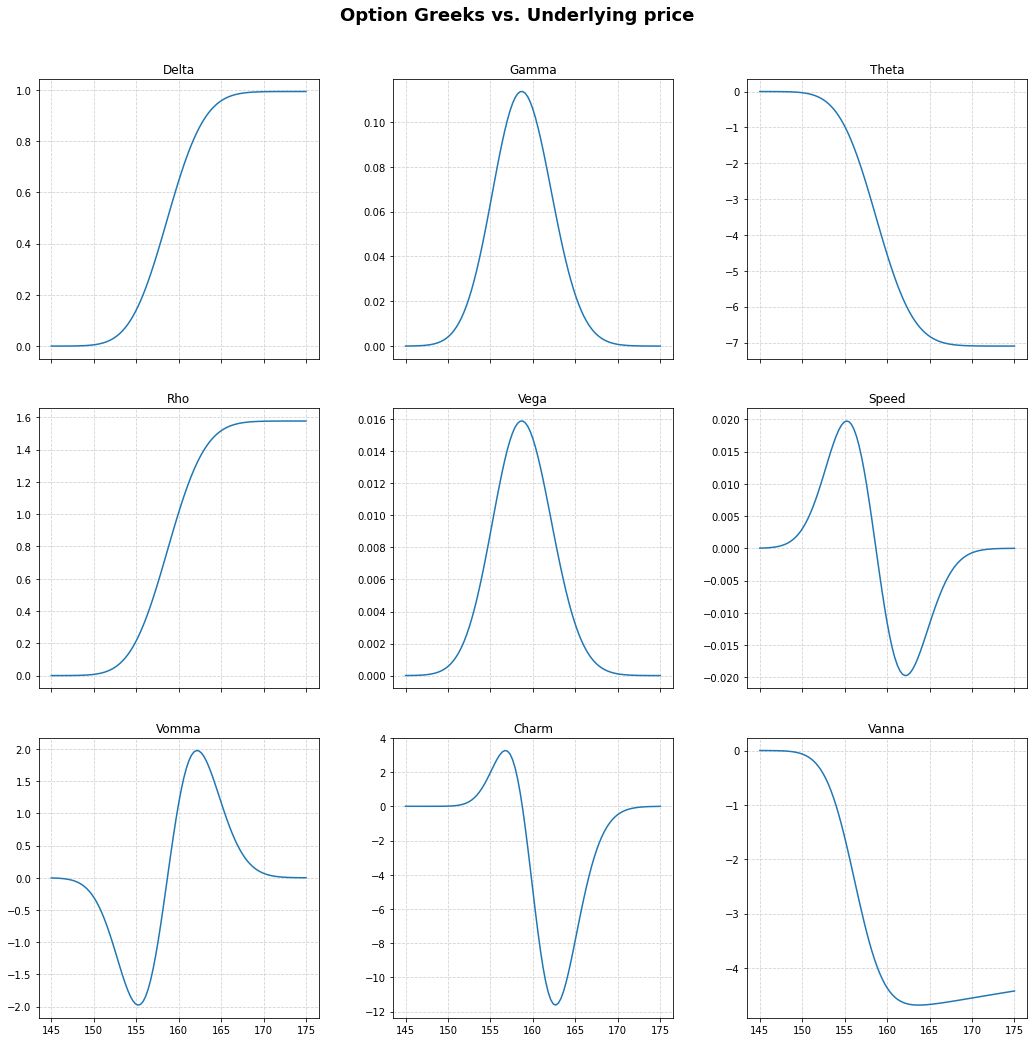

In [54]:
# Creating y-axis variables for easier change in the plots
x = np.linspace(S-15, S+15, 101)
y1 = delta
y2 = gamma
y3 = theta
y4 = rho
y5 = vega
y6 = speed
y7 = vomma
y8 = charm
y9 = vanna

# Create the subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True)

# Set the titles of each subplot
titles = ['Delta', 'Gamma', 'Theta',
          'Rho', 'Vega', 'Speed',
          'Vomma', 'Charm', 'Vanna']

# Loop through each subplot and plot the data
for i, ax in enumerate(axs.flat):
    # Set the title of the subplot
    ax.set_title(titles[i])
    
    # Plot the data on the subplot
    if i == 0:
        ax.plot(x, y1)
    elif i == 1:
        ax.plot(x, y2)
    elif i == 2:
        ax.plot(x, y3)
    elif i == 3:
        ax.plot(x, y4)
    elif i == 4:
        ax.plot(x, y5)
    elif i == 5:
        ax.plot(x, y6)
    elif i == 6:
        ax.plot(x, y7)
    elif i == 7:
        ax.plot(x, y8)
    elif i == 8:
        ax.plot(x, y9)
    
    # Add a grid to the subplot
    ax.grid(color='lightgray', linestyle='--')
    


# Set the overall title of the figure
fig.suptitle('Option Greeks vs. Underlying price', fontsize=18, fontweight='bold')

# Adjust the spacing between the subplots
fig.tight_layout(pad=3)

# Show the figure
plt.show()